## Reproducing results of FD004

In this notebook, we will reproduce results of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/attention_based_RUL/CMAPSS_FD004_additive_attention_early_rul_150_GRU_based_final.ipynb).

To reproduce our results, we will follow these steps:

* Preprocess test data
* Create model
* Load model weights, and
* Make prediction

To preprocess test data, we need scaling parameters of training data. Ideally, we can save scaling parameter of training data and use it to scale test data. However, in our case, we have unnecessarily processed training data first before processing test data. This is not a good practice for large datasets. It can easily be avoided.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.4.1
Numpy version:  1.19.2
Pandas version:  1.2.4
Scikit-learn version:  0.24.1


## Prepare test data

We will again use the same functions to preprocess test data. As mentioned above, we will be unnecessarily processing training data.

In [2]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [3]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    dec_input_data = np.repeat(np.nan, repeats = num_batches * num_features).reshape(num_batches, 1, num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            dec_input_data[batch, :, :] = output_data[batch, :, :][-1]
        return output_data, dec_input_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [4]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        test_decoder_for_an_engine = test_data_for_an_engine[-1][np.newaxis, np.newaxis, :]
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :], test_decoder_for_an_engine                                                
    
    else:
        max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
        
        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine, test_decoder_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask, test_decoder_for_an_engine
        
        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine, test_decoder_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask,  test_decoder_for_an_engine

In [5]:
train_data = pd.read_csv("/home/biswajit/data/cmapss_data/train_FD004.txt", sep= "\s+", header = None)
test_data = pd.read_csv("/home/biswajit/data/cmapss_data/test_FD004.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("/home/biswajit/data/cmapss_data/RUL_FD004.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 150         
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

# train_mask = []
test_mask = []
test_decoder_input = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
# scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    

    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine, test_decoder_input_for_an_engine = process_test_data(temp_test_data,
                                                                                                          window_length = window_length,
                                                                                                          shift = shift,
                                                                                                          num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)
    test_decoder_input.append(test_decoder_input_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)
test_decoder_input = np.concatenate(test_decoder_input)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("Test decode input shape: ", test_decoder_input.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (54028, 30, 21)
Processed training ruls shape:  (54028,)
Processed test data shape:  (1196, 30, 21)
Test mask shape:  (1196, 30)
Test decode input shape:  (1196, 1, 21)
True RUL shape:  (248,)


In [6]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [7]:
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask, test_decoder_input)).batch(128).prefetch(tf.data.AUTOTUNE)

## Build model

In [8]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs): 
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
    
    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`, `num_features`)
        output = self.rnn(X, *args, **kwargs) # Shape of output: (batch_size, num_steps, num_hiddens)
        state = output[1:]                        # Shape of state: (batch_size, num_hiddens)
        return (output[0], state)

In [9]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size)
        
    def call(self, state, encoder_outputs):
        # Shape of encocder_outputs: (batch_size, num_steps, hidden_dims)
        # Shape of state: (batch_size, hidden_dims)
        seq_len = encoder_outputs.shape[1]
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))  # Shape of score: (batch_size, num_steps, attention_size)
        # Shape of attention_weights: (batch_size, num_steps)
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1) 
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)

In [10]:
class Seq2SeqAttentionDecoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)
        
    def init_state(self, enc_outputs, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)
    
    
    def call(self, dec_input, state, **kwargs):
        # Shape of dec_input: (batch_size, 1, num_features)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, enc_hidden_state = state
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(enc_hidden_state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, initial_state = enc_hidden_state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output, rnn_output[1:]

In [11]:
class EncoderDecoder(tf.keras.Model):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args, **kwargs):
        enc_outputs = self.encoder(enc_X, *args, **kwargs)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, **kwargs)

In [12]:
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)

## Create full model

In [13]:
net = EncoderDecoder(encoder, decoder)

## Load saved weights

In [14]:
net.load_weights("./saved_weights/FD004/FD004_early_rul_150_GRU_rmse_26_78")

## Make predictions

In [15]:
def predict_seq2seq(net, test_data_iter):
    final_preds = []
    for test_data_batch, test_mask_batch, test_dec_input in test_data_iter:
        enc_outputs = net.encoder(test_data_batch, mask = test_mask_batch, training = False)
        dec_state = net.decoder.init_state(enc_outputs)
        Y_pred, _ = net.decoder(test_dec_input, dec_state, training = False)
        final_preds.append(Y_pred.numpy())
    return tf.squeeze(tf.concat(final_preds, axis = 0).numpy()).numpy()

In [16]:
rul_pred_unscaled = predict_seq2seq(net, test_dataset)

In [17]:
rul_pred = target_scaler.inverse_transform(rul_pred_unscaled.reshape(-1, 1)).reshape(-1)

## RMSE and MAE using last 5 examples

In [18]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

RMSE:  26.24487869577749
MAE:  20.209899968822157


## RMSE and MAE using only last example

In [19]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last examples):  26.777962589576784
MAE (Taking only last example):  20.310919066830987


## S score

In [20]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [21]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  7096.229172309887


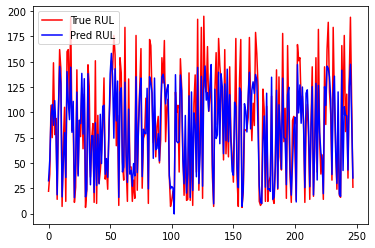

In [22]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()